In [1]:
import sympy as smp
import matplotlib.pyplot as plt
smp.init_printing(use_latex='mathjax')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
from xnp import *
backend = 'cupy' if getattr(np, '__name__', '') == 'cupy' else 'numpy'
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using NumPy and SciPy on CPU


In [2]:
#Lets find some entropy

In [3]:
rmax = 1000000000
num = 1000

In [82]:
#lets do a 4d planar BH
d=4
k=0
#placeholders for other vars
# the issue with these guys is that i have absolutely zero clue what "sensible" values would be for these
l=1
q=0
mu=0

In [ ]:
#lets define some functions?
def f(r,l=l,q=q,mu=mu,d=d,k=k):
    return k - mu*(r**(2-d)) + (q**2)*(r**(4-2*d)) + (r**2)/(l**2)

def fp(r,l=l,q=q,mu=mu,d=d):
    return (d-2)*mu*(r**(1-d)) + (4-2*d)*(q**2)*(r**(3-2*d))+ 2*r/(l**2)

def beta(R):
    return 4 * np.pi / fp(R)

def gamma2(r0):
    # return -1*f(r0)*(r0**(2*d-4))
    # i have no clue if this is going to do what i want it to, but lets hope gamma squared does some nice conjugation thing
    return 1*f(r0)*(r0**(2*d-4))

In [84]:
#lets get a nice correlation between alpha and r0
# tried to keep this all vectorized, but was getting weird outputs and not the right divergences so its time for for loops (yippee!!!)
def k1(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rbar = R / 2
        rgrid = np.linspace(rbar,r0,num)
        sum =  (4 * np.pi / beta(R)) * np.trapz(1/f(rgrid),rgrid)
        list.append(sum)
    return np.array(list)

def k2(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.logspace(np.log10(R),np.log10(rmax),num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0)))))/f(rgrid)
        sum = (2*np.pi/beta(R)) * np.trapz(integ,rgrid)
        list.append(sum)
    return np.array(list)

def k3(r0grid,R):
    list = []
    for i in range(num):
        r0 = r0grid[i]
        rgrid = np.linspace(r0,R,num)
        integ = (1 - 1/(np.sqrt(1+f(rgrid)*(rgrid**(2*d-4))/(gamma2(r0)))))/f(rgrid)
        sum = (4*np.pi/beta(R)) * np.trapz(integ,rgrid)
        list.append(sum)
    return np.array(list)

In [85]:
def alpha(r0grid,R):
    return 2*np.exp(k1(r0grid,R)+k2(r0grid,R)+k3(r0grid,R))

In [86]:
#lets get an array relating r0 to alpha for fixed R=10
R = 10
r0grid = np.linspace(0.1,R,num)
alphagrid = alpha(r0grid,R)

k1grid = k1(r0grid,R)
#k1grid = k1grid.get()

k2grid = k2(r0grid,R)
#k2grid = k2grid.get()

k3grid = k3(r0grid,R)
#3grid = k3grid.get()


# need to convert from CuPy array to NumPy array, something about being on the GPU.. if this breaks on mac just comment it all out lol
#r0grid = r0grid.get()
#alphagrid = alphagrid.get()

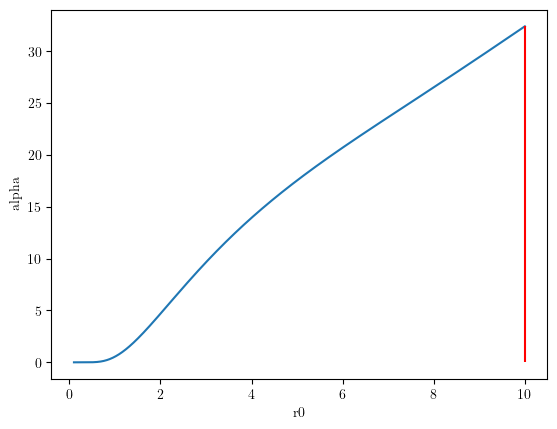

In [87]:
plt.plot(r0grid,alphagrid)
plt.xlabel('r0')
plt.ylabel('alpha')
plt.vlines(R,alphagrid.min(),alphagrid.max(),colors='r')
# plt.semilogx()
plt.show()

In [88]:
#now just have to integrate our area functional from inf to R, from R to r0...
#i guess we can just do this a million billion times, varying alpha -> varying r0
#this will be so fun yippee!!!!

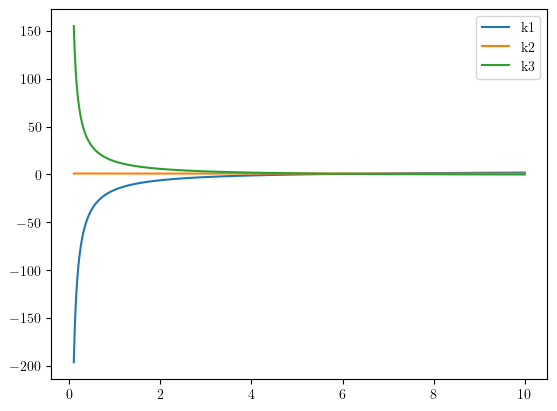

In [93]:
plt.plot(r0grid,k1grid,label='k1')
plt.plot(r0grid,k2grid,label='k2')
plt.plot(r0grid,k3grid,label='k3')
plt.legend()
# plt.semilogx()
# plt.semilogy()


In [ ]:
# ok so heres what i think my issue is
# we need our redshift function to be informed by R, which means at least one of those parameters needs to depend on R
# mu is 0,k is also 0, we think about uncharged BHs here, so the only option is l
# 